In [1]:
from utils import *
import pandas as pd
import seaborn as sns

In [2]:
#  차트 설정
import matplotlib.pyplot as plt
# plt.rcParams["font.family"] = 'Malgun Gothic'
plt.rcParams["font.family"] = 'AppleGothic'
# plt.rcParams["figure.figsize"] = (14,4)
# plt.rcParams['lines.linewidth'] = 2
# plt.rcParams["axes.grid"] = True
plt.rcParams['axes.unicode_minus'] = False

# Step 1. 뉴딜지수 클러스터링 결과로 임의의 클러스터 데이터 추출

In [3]:
cluster_df = pd.read_csv('뉴딜지수.csv')
cluster_df.head(2)

,Name,Close,Close.1,Cluster
0,CMG제약,0.279832,-0.306899,2
1,HK이노엔,0.282858,-0.630700,2


In [4]:
newdeal_list = cluster_df[cluster_df['Cluster']==2]['Name'].to_numpy()
newdeal_list

array(['CMG제약', 'HK이노엔', '대한뉴팜', '보령', '유나이티드제약', '유한양행', '하이텍팜'],
      dtype=object)

In [5]:
krx_list = get_KRX_list()
df = pd.DataFrame(krx_list)
stock_list = df[df['Name'].isin(newdeal_list)]

start_date, end_date = '20200101', '20221231'
origin_data = get_close_data(stock_list['Code'], stock_list['Name'], start_date, end_date)
price = origin_data.copy()

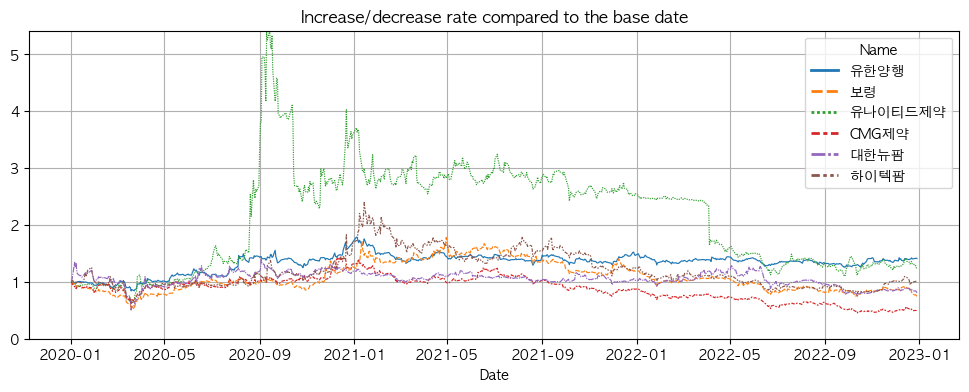

In [6]:
# step1
price_rate = price/price.iloc[0] 

plt.figure(figsize=(12,4))
sns.lineplot(data=price_rate, linewidth=0.85)
plt.ylim((0, price_rate.max().max()))
plt.title('Increase/decrease rate compared to the base date')
plt.show()


# Step 2. 일일 수익률, 최종 수익률 시각화

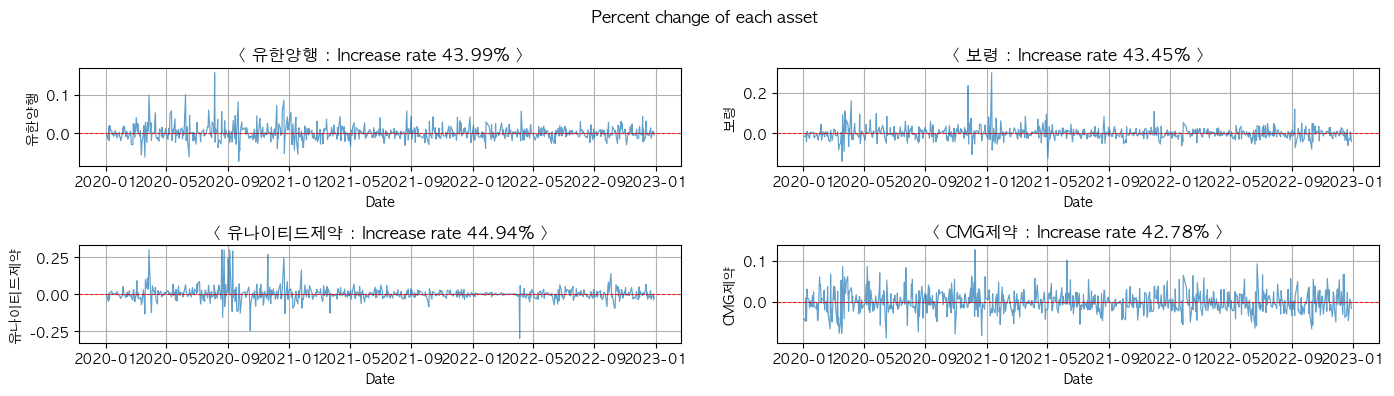

In [7]:
pcc = price.pct_change().iloc[1:,:] # 첫째 날 데이터 제거(NaN)

for i in range(4):

    data = pcc.iloc[:,i]
    plt.subplot(int(f'22{i+1}'))
    sns.lineplot(data=data, linewidth=0.85, alpha=0.7)
    inc_rate = (data > 0).sum() / len(data) * 100
    plt.title(f'< {data.name} : Increase rate {inc_rate:.2f}% >')
    plt.axhline(y=0, color='r', linestyle='--', linewidth=0.7, alpha=0.9)

plt.suptitle('Percent change of each asset')
plt.tight_layout()
plt.show()

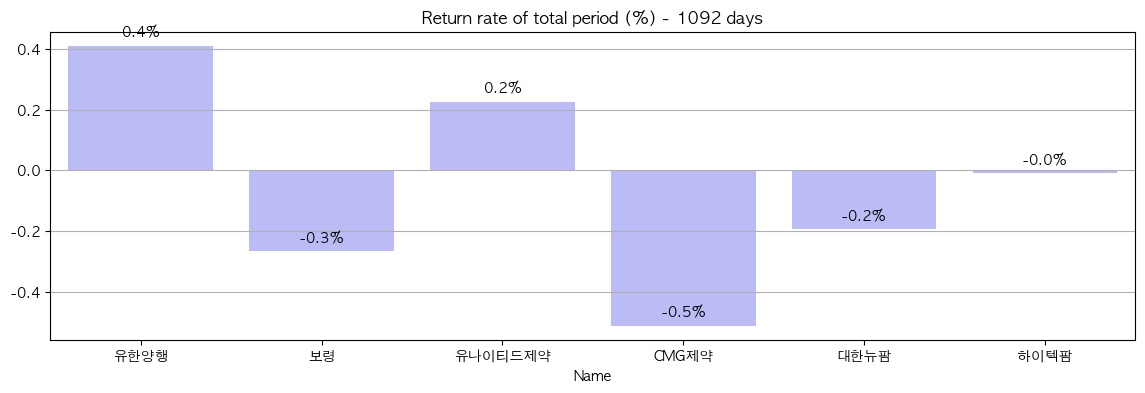

In [8]:
# start_date, end_date = '20200101', '20221231' 수익률
return_rate = (price.iloc[-1,:] - price.iloc[0,:])/price.iloc[0,:]

bars = sns.barplot(x=return_rate.index, y=return_rate.values, color='Blue', alpha=0.3)
for p in bars.patches:
    bars.annotate(f'{p.get_height():.1f}%',
                  (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va='center',
                   xytext = (0,9),
                   textcoords = 'offset points')
    
plt.title(f'Return rate of total period (%) - {(price.index[-1] - price.index[0]).days} days')
plt.show()

# Step 3. 일일 수익률 간 상관관계 시각화
블로그: 가능하다면 상관계수가 0.2 이하의 낮은 수준으로 자산 조합을 선택하는 것이 좋다

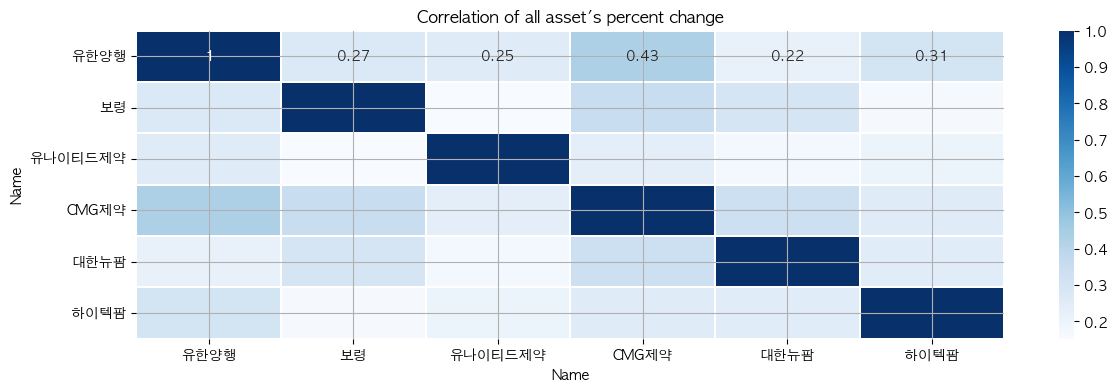

In [9]:
plt.title("Correlation of all asset's percent change")
sns.heatmap(price.pct_change().corr(), cmap='Blues', linewidth=0.2, annot=True)
plt.show()


# Step 4. 변동성(위험) 대비 수익률 시각화

In [10]:
import numpy as np

port_ratios = []
port_returns = np.array([])
port_risks = np.array([])
for i in range(10000): # 포트폴리오 비율 조합 10000개
    # 포트폴리오 비율
    port_ratio = np.random.rand(len(price.columns)) # 4가지 랜덤 실수 조합
    port_ratio /= port_ratio.sum() # 합계가 1인 랜덤 실수
    port_ratios.append(port_ratio)
    
    # 연 평균 수익률
    total_return_rate = price.iloc[-1] / price.iloc[0] # 총 수익률(%)
    # total_return_rate = (price.iloc[-1] + dividends.sum()) / price.iloc[0] # 배당금 합산 총 수익률(%)
    annual_avg_rr = total_return_rate ** (1/10) # 연 (기하)평균 수익률(%)
    port_return = np.dot(port_ratio, annual_avg_rr-1) # 연 평균 포트폴리오 수익률 = 연 평균 수익률과 포트폴리오 비율의 행렬곱
    port_returns = np.append(port_returns, port_return)
    
    # 연간 리스크
    annual_cov = price.pct_change().cov() * len(price)/10 # 연간 수익률의 공분산 = 일별 수익률 공분산 * 연간 평균 거래일수
    port_risk = np.sqrt(np.dot(port_ratio.T, np.dot(annual_cov, port_ratio))) # E(Volatility) = sqrt(WT*COV*W)
    port_risks = np.append(port_risks, port_risk)


In [11]:
sorted_shape_idx = np.argsort(port_returns/port_risks)
sorted_risk_idx = np.argsort(port_risks)

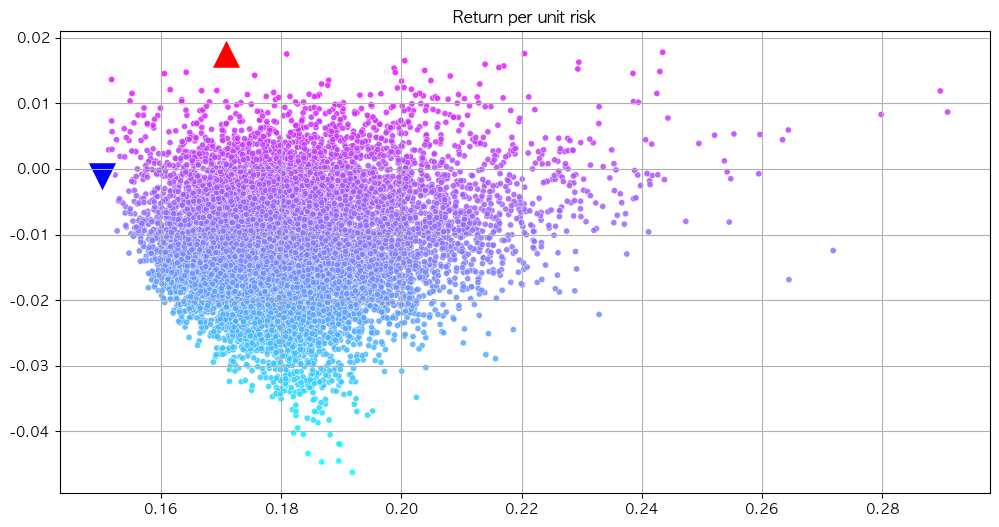

In [12]:
plt.figure(figsize=(12,6))
sns.scatterplot(x=port_risks, y=port_returns, c=port_returns/port_risks, cmap='cool', alpha=0.85, s=20)
sns.scatterplot(x=port_risks[sorted_shape_idx[-1:]], y=port_returns[sorted_shape_idx[-1:]], color='r', marker='^', s=500)
sns.scatterplot(x=port_risks[sorted_risk_idx[:1]], y=port_returns[sorted_risk_idx[:1]], color='b', marker='v', s=500)

plt.title('Return per unit risk')
plt.show()

# Step 5. 샤프 지수에 따른 포트폴리오 비율 시각화

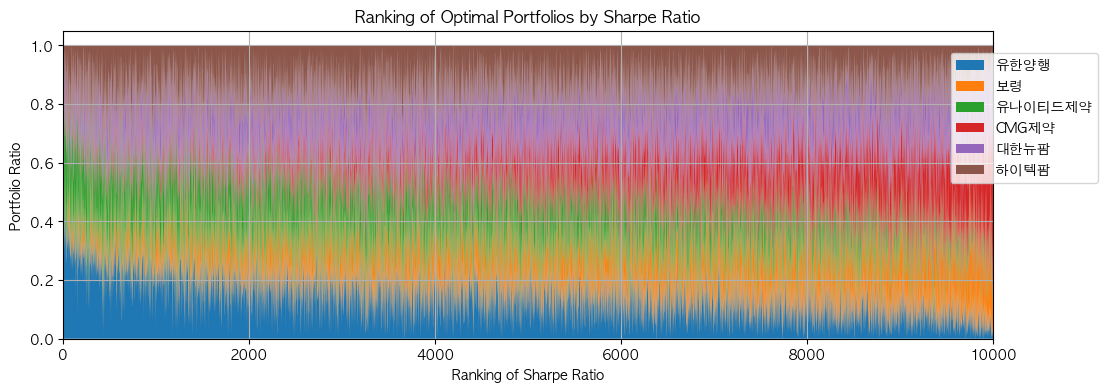

In [13]:
port_df = pd.DataFrame(port_ratios)
sorted_port_df = port_df.iloc[sorted_shape_idx[::-1]] # 역순
sorted_port_df.columns = price.columns

plt.figure(figsize=(12,4))
plt.stackplot(np.arange(1,len(sorted_port_df)+1,1), np.array(sorted_port_df.T), labels=sorted_port_df.columns)

plt.xlim(0,10000)
plt.legend(bbox_to_anchor=(1.12,0.95))
plt.xlabel('Ranking of Sharpe Ratio')
plt.ylabel('Portfolio Ratio')
plt.title('Ranking of Optimal Portfolios by Sharpe Ratio')
plt.show()

# Step 6. 샤프 지수에 따른 포트폴리오 수익률 및 변동성 시각화
뉴딜지수 Cluster:2 는 안좋은 포폴...

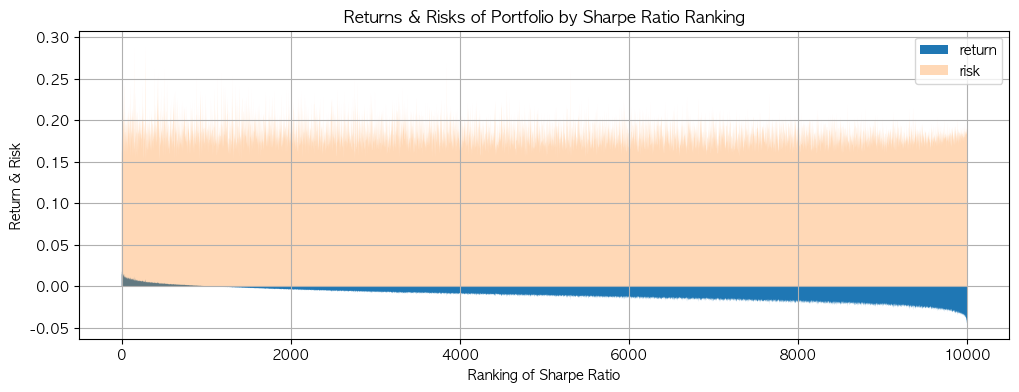

In [14]:
sorted_returns = port_returns[[sorted_port_df.index]].reshape(-1,)
sorted_risks = port_risks[[sorted_port_df.index]].reshape(-1,)

plt.figure(figsize=(12,4))
plt.fill_between(x=np.arange(1,len(sorted_returns)+1,1), y1=sorted_returns.tolist(), label='return')
plt.fill_between(x=np.arange(1,len(sorted_risks)+1,1), y1=sorted_risks.tolist(), alpha=0.3, label='risk')
plt.xlabel('Ranking of Sharpe Ratio')
plt.ylabel('Return & Risk')
plt.title('Returns & Risks of Portfolio by Sharpe Ratio Ranking')
plt.legend()
plt.show()

# Step 7. 최적의 포트폴리오 비율


In [15]:
print(f'최적의 포트폴리오 비율 : \n{pd.Series(sorted_port_df.iloc[0], index=sorted_port_df.columns)}')

최적의 포트폴리오 비율 : 
Name
유한양행       0.535569
보령         0.006973
유나이티드제약    0.171325
CMG제약      0.060093
대한뉴팜       0.003438
하이텍팜       0.222601
Name: 9506, dtype: float64
